# Summarize Void Growth and Movement
Determine whether time or size affect the mobility or growth rates of voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colormaps
from scipy.optimize import minimize
from scipy.stats import norm
from functools import partial
from multiprocessing import Pool
from pathlib import Path
from cycler import cycle
import pandas as pd
import numpy as np
import emcee
import json

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Other key paths

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name

## Load the Smoothed Tracks
We are going to start from the tasks after smoothing them with splines

In [4]:
track_data = pd.read_csv(out_directory / 'smoothed_tracks.csv')
print(f'Loaded {len(track_data)} records from {len(track_data["void"].value_counts())} voids')

Loaded 12195 records from 77 voids


In [5]:
track_data.head()

,void,frame,radius,radius_dt,velocity_mag,position-x,position-y,color
0,309,359,2.550270,0.008534,0.011464,406.337277,295.031708,[0.647257 0.8584 0.209861 1. ]
1,7,534,9.702548,0.000445,0.000364,112.722406,333.962385,[0.150476 0.504369 0.55743 1. ]
2,1,431,8.534464,0.005943,0.002524,391.599824,59.638670,[0.119483 0.614817 0.537692 1. ]
3,4,377,8.104264,0.000762,0.003526,44.649238,216.845036,[0.647257 0.8584 0.209861 1. ]
4,54,212,2.169712,-0.043048,0.033766,475.160147,482.629605,[0.282623 0.140926 0.457517 1. ]


## Detect Outliers
See if any of the growth rates are particularly unlikely compared to the others. We are going to use methods based on the IQR for simplicity's sake

### Growth
From the previous notebook, we can see that growth terms are relatively smooth. So, I'm leery to refer to points as outliers unless they are far out

In [6]:
iqr_rdt = np.diff(np.percentile(track_data['radius_dt'], [25, 75]))[0]

In [7]:
k = 5  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['radius_dt'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['radius_dt'], 25) - k * iqr_rdt

Text(0, 0.5, 'Count')

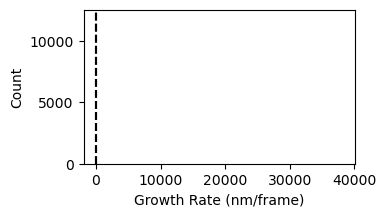

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['radius_dt'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Growth Rate (nm/frame)')
ax.set_ylabel('Count')

In [9]:
track_data['growth_outlier'] = np.logical_or(track_data['radius_dt'] > upper_thr, track_data['radius_dt'] < lower_thr)
print(f'Found {track_data["growth_outlier"].sum()} outliers')

Found 755 outliers


### Movement
Movement is more jittery but I need to be less aggressive on movement rates because most voids are sessile. Only the rare void moves

In [10]:
iqr_rdt = np.diff(np.percentile(track_data['velocity_mag'], [25, 75]))[0]

In [11]:
k = 8  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['velocity_mag'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['velocity_mag'], 25) - k * iqr_rdt
print(f'Bounds for movement: {upper_thr:.3f}, {lower_thr:.3f}')

Bounds for movement: 0.396, -0.347


Text(0, 0.5, 'Count')

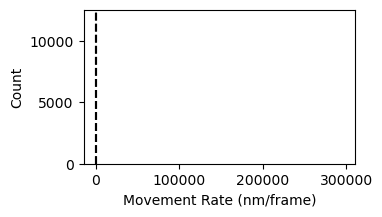

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['velocity_mag'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Movement Rate (nm/frame)')
ax.set_ylabel('Count')

In [13]:
track_data['movement_outlier'] = np.logical_or(track_data['velocity_mag'] > upper_thr, track_data['velocity_mag'] < lower_thr)
print(f'Found {track_data["movement_outlier"].sum()} outliers')

Found 1166 outliers


### Drop outliers
Exclude if it is an outlier for either

In [14]:
old_size = len(track_data)
track_data.query('not (movement_outlier or growth_outlier)', inplace=True)
print(f'New size: {len(track_data)}. {len(track_data) / old_size * 100:.2f}% passed.')

New size: 10744. 88.10% passed.


## Re-plot the void tracks
Drop the first and last 5 frames of the void track. Those are right where the void moved or changed enough that it 

Assign a random color to each void

In [15]:
cmap = colormaps['nipy_spectral']

In [16]:
colors = np.linspace(0, 1, len(track_data['void'].value_counts()))
rng = np.random.RandomState(1)
rng.shuffle(colors)
colors = cmap(colors)

In [17]:
known_voids = sorted(set(track_data['void']))
track_data['color'] = track_data['void'].apply(known_voids.index).apply(colors.__getitem__)

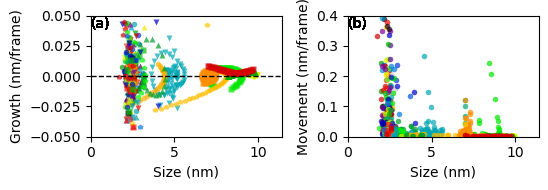

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for (gid, group), m in zip(track_data.groupby('void'), cycle('osv^p')):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], m, 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/frame)')

for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

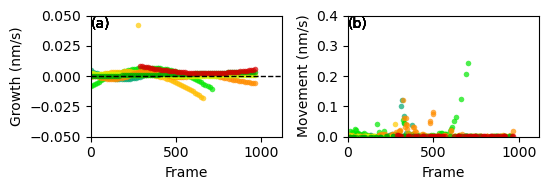

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['radius_dt'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/s)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/s)')

for ax in axs:
    ax.set_xlabel('Frame')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-time.png', dpi=320)

## Fit a model for void growth and movement
We can assume that both the mean and variance of growth rate for a void is a function of size.

$\dot{r} \sim N(\alpha_0 + \alpha_1 r, 10^{\beta_0 + \beta_1 r})$

We fit this distribution my minimizing the log-likelihood of the observed data, which are pairs of $r$ and $\dot{r}$.

Similar logic holds for

In [20]:
def get_size_distribution(r: float | np.ndarray, params: list[float]):
    """Get the expected growth rate distribution of a void given its size
    
    Args:
        radius: Sizes of the void
        params: Parameters for the distribution model.
            Ordered as [alpha, beta]
    Returns:
        Distribution for all voids
    """
    return norm(params[0] + params[1] * r, np.power(10, params[2] + params[3] * r))

Fit the model

In [21]:
def log_probability(params: list[float], data: pd.DataFrame, target_column: str = 'radius_dt') -> float:
    """Compute the log probability of the data given a 
    model which explains the property being an effect of 
    radius.
    
    Args:
        params: Parameters for the distribution. We assume the parameters for the 
        data: Data of the void distribution
        target_column: Column being fit
    """
    
    r = data['radius']
    growth_dist = get_size_distribution(r, params)
    ll = growth_dist.logpdf(data[target_column])
    return ll.sum()

In [22]:
result = minimize(lambda x, y: -log_probability(x, y), [0, 0, -1, 0], args=(track_data,))
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -38562.71026828948
        x: [-2.343e-03  4.128e-04 -1.452e+00 -1.286e-01]
      nit: 16
      jac: [-6.836e-03 -3.418e-02 -1.465e-03 -7.812e-03]
 hess_inv: [[ 5.401e-08 -6.129e-09 -7.555e-08  2.180e-08]
            [-6.129e-09  7.145e-10  8.548e-09 -2.447e-09]
            [-7.555e-08  8.548e-09  6.326e-07 -4.944e-07]
            [ 2.180e-08 -2.447e-09 -4.944e-07  4.664e-07]]
     nfev: 175
     njev: 35

In [23]:
growth_params = result.x
print(f'Void growth is defined by: {growth_params[0]:.2e} + {growth_params[1]:.2e} * r')

Void growth is defined by: -2.34e-03 + 4.13e-04 * r


Repeat for movement

In [24]:
track_data['log_velocity_mag'] = np.log(track_data['velocity_mag'])
result = minimize(lambda x: -log_probability(x, track_data, 'velocity_mag'), [-3, 0, 0, 0])
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -18648.56909437898
        x: [ 5.987e-02 -6.043e-03 -9.966e-01 -6.641e-02]
      nit: 35
      jac: [ 9.766e-04  8.057e-03  0.000e+00 -2.441e-04]
 hess_inv: [[ 1.618e-06 -1.957e-07 -7.101e-07  1.301e-07]
            [-1.957e-07  2.560e-08  9.291e-08 -1.697e-08]
            [-7.101e-07  9.291e-08  4.810e-05 -6.960e-06]
            [ 1.301e-07 -1.697e-08 -6.960e-06  1.235e-06]]
     nfev: 511
     njev: 100

In [25]:
movement_params = result.x
print(f'Log void movement is defined by: {movement_params[0]:.2e} + {movement_params[1]:.2e} * r')

Log void movement is defined by: 5.99e-02 + -6.04e-03 * r


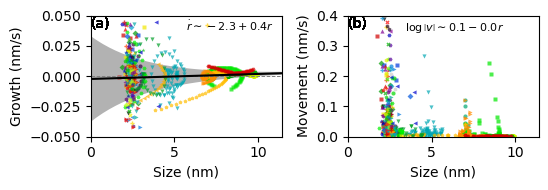

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

marker_list = 'osv^p<>hHP*XD'

# Plot the growth
ax = axs[0]
for (gid, group), m in zip(track_data.groupby('void'), cycle(marker_list)):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], m, 
            ms=3, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], '--', c='gray', lw=0.7)
ax.set_ylabel('Growth (nm/s)')
ax.set_ylim(-0.05, 0.05)

ax.text(0.5, 0.87, f'$\dot{{r}}\sim{growth_params[0]*1000:.1f}{growth_params[1]*1000:+.1f}r$',
       transform=ax.transAxes, fontsize=8)

steps = np.linspace(*ax.get_xlim(), 32)
mean = growth_params[0] + steps * growth_params[1]
std = np.power(10, growth_params[2] + growth_params[3] * steps)
ax.plot(steps, mean, 'k')
ax.fill_between(steps, mean + std, mean - std, alpha=0.3, color='k', edgecolor='none')

# Plot the movement
ax = axs[1]
for (gid, group), m in zip(track_data.groupby('void'), cycle(marker_list)):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], m, 
            ms=3, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/s)')

ax.text(0.3, 0.87, f'$\log\\left|v\\right|\sim{movement_params[0]:.1f}{movement_params[1]:+.1f}r$',
       transform=ax.transAxes, fontsize=8)

steps = np.linspace(*ax.get_xlim(), 32)
mean = movement_params[0] + steps * movement_params[1]
std = np.power(10, movement_params[2] + movement_params[3] * steps)
ax.plot(steps, np.exp(mean), 'k')
ax.fill_between(steps, np.exp(mean + std), np.exp(mean - std), alpha=0.3, color='k', edgecolor='none')


for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

Save the model parameters

In [27]:
with (out_directory / 'growth-parameters.json').open('w') as fp:
    json.dump({
        'growth': growth_params.tolist(),
        'movement': movement_params.tolist()
    }, fp)

## Use MCMC Sampling to Estimate Parameter Uncertainties
The above only gives us point estimates for the values of the parameters, which are a good place to start but limited. It would be better to have uncertainties of each parameter, which we can access with Bayesian methods.

Here, we apply [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to establish a distribution for all of our model parameters. In short, we'll build a tool that can generate samples from a distribution of likely parameters given the log probability function I created above.

We follow the [tutorial for EMCEE](https://emcee.readthedocs.io/en/stable/tutorials/line/).

Start with the growth parameters. First step is to make an initial guess and the sampler

In [28]:
pos = growth_params + 1e-4 * np.random.randn(32, len(growth_params))
n_walkers, n_dim = pos.shape

In [29]:
prob_fun = partial(log_probability, data=track_data)
sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, prob_fun
)

Then burn in and find the autocorrelation time. If the autocorrelation time fails, then add more samples

In [30]:
state = sampler.run_mcmc(pos, 5000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:23<00:00, 34.78it/s]


In [31]:
for _ in range(5):
    try:
        act = sampler.get_autocorr_time().max()
        break
    except emcee.autocorr.AutocorrError:
        state = sampler.run_mcmc(state, 5000, progress=True)
else:
    raise ValueError('Did not converge')
print(f'Assuming an autocorrelation time of {act:.1f}')

Assuming an autocorrelation time of 50.0


Run the autocrrelation for a fair number of steps where we pick the 

In [32]:
samples = sampler.get_chain(discard=int(act*8), thin=int(act / 2), flat=True)
print(f'Pulled {samples.shape[0]} samples.')

Pulled 6112 samples.


Compute the mean and covariance

In [33]:
growth_covariance = np.cov(samples.T)

In [34]:
growth_means = np.mean(samples, axis=0)

Repeat for the movement parameters

In [63]:
pos = movement_params + 1e-4 * np.random.randn(32, len(movement_params))
n_walkers, n_dim = pos.shape

In [64]:
prob_fun = partial(log_probability, data=track_data, target_column='log_velocity_mag')
sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, prob_fun
)
state = sampler.run_mcmc(pos, 50, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.58it/s]


In [65]:
for _ in range(5):
    try:
        act = sampler.get_autocorr_time().max()
        if np.isnan(act):
            raise ValueError()
        break
    except (emcee.autocorr.AutocorrError, ValueError):
        state = sampler.run_mcmc(state, 5000, progress=True)
else:
    raise ValueError('Did not converge')
print(f'Assuming an autocorrelation time of {act:.1f}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:22<00:00, 35.09it/s]


Assuming an autocorrelation time of 125.2


In [66]:
samples = sampler.get_chain(discard=int(act*8), thin=int(act / 2), flat=True)
print(f'Pulled {samples.shape[0]} samples.')

Pulled 4640 samples.


In [67]:
move_covariance = np.cov(samples.T)
move_means = np.mean(samples, axis=0)

Save the Bayesian results

In [69]:
with (out_directory / 'growth-parameters-bayesian.json').open('w') as fp:
    json.dump({
        'growth': {'mean': growth_means.tolist(), 'covar': growth_covariance.tolist()},
        'movement': {'mean': move_means.tolist(), 'covar': move_covariance.tolist()}
    }, fp)